In [3]:
# install dependencies

%pip install IPython
%pip install -q atlassian-python-api
%pip install -q matplotlib
%pip install -q numpy
%pip install -q tqdm
%pip install -q ipywidgets

from IPython.display import clear_output
clear_output()

In [1]:
import base64
import io
import json
import re
import requests
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from atlassian import Jira
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from tqdm.auto import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

class UltimateSprintReport:

	class DataPoint:

		def __init__(
			self,
			name: str,
			count: int,
			points: float,
			color: str,
			hatch: str,
			edge_color: str
		):
			self.name = name
			self.count = count
			self.points = points
			self.color = color
			self.hatch = hatch
			self.edge_color = edge_color

		def get_values(self):
			return [self.count, self.points]
		
		def __repr__(self):
			return str({"name": self.name, "count": self.count, "points": self.points})
		
	def __init__(self, username: str, password: str, jira_url: str):
		"""
		Initialize the UltimateSprintReport with Jira credentials.
		
		:param username: The username.
		:param password: The atlassian api key for cloud instances otherwise password.
		:param jira_url: The URL of the Jira instance.
		"""
		if (jira_url is None) or (username is None) or (password is None):
			raise ValueError("Jira URL, username and password are required")        
		self.jira = Jira(url=jira_url, username=username, password=password, cloud=True)

	def load(self, host: str, project: str, board_id: int, sprint_id: int):
		"""
		Load the sprint report data from the parameters provided.
		
		:param project: The Project of the sprint report.
		:param board id: The id of the board the sprint belongs to (also known as the rapid view id).
		:param sprint id: The id of the sprint.
		:return: The UltimateSprintReport instance.
		"""
		if host[-1] != "/":
			host += "/" 
			
		sprint_url = f"{host}jira/software/c/projects/{project}/boards/{board_id}/reports/sprint-retrospective?sprint={sprint_id}"
		return self.load_url(sprint_url)
	
	def load_url(self, sprint_report_url: str):
		"""
		Load the sprint report data from the given URL.
		
		:param sprint_report_url: The URL of the sprint report.
		:return: The UltimateSprintReport instance.
		"""
		self.test_case_statistics_data_table = None # reset test case statistics data table
		self.progress_bar = tqdm(total=100, desc="Loading Sprint Details", leave=True)
		self.progress_bar.n = 0
		self.progress_bar.refresh()

		self.progress_bar.set_postfix_str("Loading sprint details")
		self._set_sprint_details(sprint_report_url)
		self.progress_bar.n = round((1 / 11) * 100, 2)
		self.progress_bar.refresh()

		self.progress_bar.set_postfix_str("Loading status categories")
		self._load_status_categories()
		self.progress_bar.n = round((2 / 11) * 100, 2)
		self.progress_bar.refresh()

		self.progress_bar.set_postfix_str("Loading sprint report")
		self._load_sprint_report()
		self.progress_bar.n = round((3 / 11) * 100, 2)
		self.progress_bar.refresh()

		self.progress_bar.set_postfix_str("Loading velocity statistics")
		self._load_velocity_statistics()
		self.progress_bar.n = round((4 / 11) * 100, 2)
		self.progress_bar.refresh()

		self.progress_bar.set_postfix_str("Loading board configuration")
		self._load_board_config()
		self.progress_bar.n = round((5 / 11) * 100, 2)
		self.progress_bar.refresh()

		self.progress_bar.set_postfix_str("Loading sprint statistics")
		self._load_sprint_statistics()
		self.progress_bar.n = round((6 / 11) * 100, 2)
		self.progress_bar.refresh()

		self.progress_bar.set_postfix_str("Loading sprint issue type statistics")
		self._load_sprint_issue_types_statistics()
		self.progress_bar.n = round((6.5 / 11) * 100, 2)
		self.progress_bar.refresh()     

		self.progress_bar.set_postfix_str("Loading committed vs planned chart")
		self._load_committed_vs_planned_chart()
		self.progress_bar.n = round((7 / 11) * 100, 2)
		self.progress_bar.refresh()

		self.progress_bar.set_postfix_str("Loading sprint details")
		self._calculate_sprint_details()
		self.progress_bar.n = round((8 / 11) * 100, 2)
		self.progress_bar.refresh()

		self.progress_bar.set_postfix_str("Loading sprint predictability")
		self._calculate_sprint_predictability()
		self.progress_bar.n = round((9 / 11) * 100, 2)
		self.progress_bar.refresh()

		self.progress_bar.set_postfix_str("Loading epic statistics")
		self._calculate_epic_statistics()
		self.progress_bar.n = round((10 / 11) * 100, 2)
		self.progress_bar.refresh()

		self.progress_bar.set_postfix_str("Loading burndown chart")
		self._load_burndown()
		self.progress_bar.n = round((11 / 11) * 100, 2)
		self.progress_bar.refresh()
		
		self.progress_bar.set_postfix_str("Completed")
		self.progress_bar.close()
		return self
	
	def _set_sprint_details(self, sprint_report_url):
		self.sprint_report_url = sprint_report_url
		self.base_url, self.project, self.rapidViewId, self.sprintId = self._parse_url(
			sprint_report_url
		)
		return self
	
	def _load_burndown(self):
		no_progress_bar = False 
		
		if not hasattr(self, 'progress_bar'):
			self.progress_bar = tqdm(total=100, desc="Loading Sprint Details", leave=True)
			no_progress_bar = True 
			
		scope = []
		alreadyDone = set()
		scopeChangeBurndownChart = json.loads(
			self.jira.request(
				absolute=True,
				method="GET",
				path="{base_url}{path}?rapidViewId={rapidViewId}&sprintId={sprintId}".format(
					base_url=self.base_url,
					path="/rest/greenhopper/1.0/rapid/charts/scopechangeburndownchart.json",
					rapidViewId=self.rapidViewId,
					sprintId=self.sprintId,
				),
			).content
		)
		sprintStart = scopeChangeBurndownChart["startTime"]
		sprintEnd = scopeChangeBurndownChart["endTime"]
		completeTime = (
			scopeChangeBurndownChart["completeTime"]
			if "completeTime" in scopeChangeBurndownChart
			else None
		)
		now = (
			scopeChangeBurndownChart["now"]
			if "now" in scopeChangeBurndownChart
			else None
		)
		alreadyCheckedForResolution = set()
		self.progress_bar.update(round(100 / 110, 2))
		total = len(scopeChangeBurndownChart["changes"].items()) * 2
		counter = -1

		for ts, changelist in scopeChangeBurndownChart["changes"].items():
			counter += 1
			self.progress_bar.n = round(((10 + (counter / total)) / 11) * 100, 2)
			self.progress_bar.refresh()
			timestamp = int(ts)
			for change in changelist:
				if change["key"] in alreadyDone:
					continue
				if (
					"column" in change
					and "done" in change["column"]
					and timestamp <= sprintStart
				):
					alreadyDone.add(change["key"])
				if change["key"] not in alreadyCheckedForResolution:
					self.progress_bar.set_postfix_str(
						"Loading issue details: " + change["key"]
					)
					issue = self.jira.issue(key=change["key"], fields="resolutiondate")
					alreadyCheckedForResolution.add(change["key"])
					if (
						issue
						and "fields" in issue
						and "resolutiondate" in issue["fields"]
						and issue["fields"]["resolutiondate"]
					):
						resolution_epoch = (
							datetime.strptime(
								issue["fields"]["resolutiondate"],
								"%Y-%m-%dT%H:%M:%S.%f%z",
							).timestamp()
							* 1000
						)
						if resolution_epoch <= sprintStart:
							alreadyDone.add(change["key"])
							
		for ts, changelist in sorted(
			scopeChangeBurndownChart["changes"].items(), key=lambda x: x
		):
			counter += 1
			self.progress_bar.n = round(((10 + (counter / total)) / 11) * 100, 2)
			self.progress_bar.refresh()
			timestamp = int(ts)

			for change in changelist:

				# Skip parent issues
				if change["key"] in scopeChangeBurndownChart["issueToParentKeys"] and not scopeChangeBurndownChart["issueToParentKeys"][change["key"]] == None:
					continue
				
				# Ignore issues that were already completed before the sprint had started
				if change["key"] in alreadyDone:
					continue

				statistic = np.nan
				lastStatus = ""
				
				if timestamp <= sprintStart:
					statistic = (
						change["statC"]["newValue"]
						if "statC" in change and "newValue" in change["statC"]
						else np.nan
					)
					if change["key"] in [x["key"] for x in scope]:
						for i in range(len(scope)):
							if scope[i]["key"] == change["key"]:
								if np.isnan(scope[i]["statistic"]):
									scope[i]["statistic"] = float(statistic)
								elif not np.isnan(statistic):
									scope[i]["statistic"] += float(statistic)
					else:
						scope.append(
							{
								"timestamp": sprintStart,
								"key": change["key"],
								"eventType": "Sprint start",
								"eventDetail": "",
								"statistic": float(statistic),
							}
						)
				elif (completeTime and timestamp <= completeTime) or (
					now and timestamp <= now
				):
					if change["key"] in [x["key"] for x in scope]:
						statistic = 0
						for i in range(len(scope)):
							if scope[i]["key"] == change["key"]:
								if np.isnan(scope[i]["statistic"]):
									# statistic = np.nan
									pass
								else:
									if float(scope[i]["statistic"]) == 0:
										statistic += 0
									else:
										statistic += -1 * float(scope[i]["statistic"])
								lastStatus = scope[i]["eventDetail"]
					if lastStatus == "Issue removed from sprint":
						if "added" in change and change["added"] == True:
							pass  # if being re-added to the sprint
						else:
							continue                    
					if "column" in change and "done" in change["column"]:
						if not np.isnan(statistic) and statistic != 0:
							statistic = -1 * abs(statistic)  # ensure its burning down
						scope.append(
							{
								"timestamp": timestamp,
								"key": change["key"],
								"eventType": "Burndown",
								"eventDetail": "Issue completed",
								"statistic": statistic,
							}
						)
					elif "added" in change and change["added"] == False:
						if not np.isnan(statistic) and statistic != 0:
							statistic = -1 * abs(statistic)  # ensure its burning down
						scope.append(
							{
								"timestamp": timestamp,
								"key": change["key"],
								"eventType": "Scope change",
								"eventDetail": "Issue removed from sprint",
								"statistic": statistic,
							}
						)
					elif "added" in change and change["added"] == True:
						scope.append(
							{
								"timestamp": timestamp,
								"key": change["key"],
								"eventType": "Scope change",
								"eventDetail": "Issue added to sprint",
								"statistic": np.nan,
							}
						)
					elif "statC" in change and "newValue" in change["statC"]:
						statistic = (
							change["statC"]["newValue"]
							if "statC" in change and "newValue" in change["statC"]
							else np.nan
						)
						if statistic != 0 and not np.isnan(statistic):
							if "oldValue" in change["statC"]:
								oldValue = change["statC"]["oldValue"]
								scope.append(
									{
										"timestamp": timestamp,
										"key": change["key"],
										"eventType": "Scope change",
										"eventDetail": f"Estimate change from {oldValue} to {statistic}",
										"statistic": statistic - oldValue,
									}
								)
							else:
								scope.append(
									{
										"timestamp": timestamp,
										"key": change["key"],
										"eventType": "Scope change",
										"eventDetail": f"Estimate of {statistic} has been added",
										"statistic": statistic,
									}
								)
					elif (
						"statC" in change
						and "oldValue" in change["statC"]
						and not "newValue" in change["statC"]
					):
						scope.append(
							{
								"timestamp": timestamp,
								"key": change["key"],
								"eventType": "Scope change",
								"eventDetail": f"Estimate of {abs(statistic)} has been removed",
								"statistic": statistic,
							}
						)
					elif (
						"statC" in change
						and change["statC"] == {}
						and "column" in change
						and "notDone" in change["column"]
						and "newStatus" in change["column"]
					):
						newStatusId = self._find_status_by_id(change["column"]["newStatus"])["name"]
						scope.append(
							{
								"timestamp": timestamp,
								"key": change["key"],
								"eventType": "Issue state change",
								"eventDetail": f"Status changed to {newStatusId}",
								"statistic": np.nan,
							}
						)
					elif (
						"column" in change
						and "notDone" in change["column"]
						and not "done" in change["column"]                      
					):
						newStatusId = (" to " + self._find_status_by_id(change["column"]["newStatus"])['name']) if "newStatus" in change["column"] else ""
						scope.append(
							{
								"timestamp": timestamp,
								"key": change["key"],
								"eventType": "Issue state change",
								"eventDetail": f"Status changed{newStatusId}",
								"statistic": np.nan,
							}
						)
					else:
						scope.append(
							{
								"timestamp": timestamp,
								"key": change["key"],
								"eventType": "UNKNOWN",
								"eventDetail": "UNKNOWN",
								"statistic": statistic,
							}
						)

		for ts, closures in scopeChangeBurndownChart["openCloseChanges"].items():
			timestamp = int(ts)
			for closure in closures:
				if "operation" not in closure:
					continue
				operation = closure["operation"].lower()
				by = closure["userDisplayNameHtml"]
				name = re.search(r">(.*?)<", by).group(1)
				if timestamp == completeTime:
					operation = "ended"
					scope.append(
						{
							"timestamp": timestamp,
							"key": "",
							"eventType": f"Sprint ended by {name}",
							"eventDetail": "",
							"statistic": np.nan,
						}
					)
				elif timestamp < completeTime:
					scope.append(
						{
							"timestamp": timestamp,
							"key": "",
							"eventType": f"Sprint {operation} by {name}",
							"eventDetail": "",
							"statistic": np.nan,
						}
					)
					
		if completeTime:
			by = scopeChangeBurndownChart["lastUserWhoClosedHtml"]
			name = re.search(r">(.*?)<", by).group(1)
			scope.append(
				{
					"timestamp": completeTime,
					"key": "",
					"eventType": f"Sprint ended by {name}",
					"eventDetail": "",
					"statistic": np.nan,
				}
			)
		scope.append(
			{
				"timestamp": sprintStart + 0.1,
				"key": "",
				"eventType": f"Sprint started",
				"eventDetail": "",
				"statistic": np.nan,
			}
		)
		if now and ((completeTime and now < completeTime) or not completeTime):
			scope.append(
				{
					"timestamp": now,
					"key": "",
					"eventType": f"Current",
					"eventDetail": "",
					"statistic": np.nan,
				}
			)

		scope.sort(key=lambda x: (x["timestamp"], x["key"]))

		df = pd.DataFrame(scope)
		df["Inc."] = df.apply(
			lambda row: row.statistic if row.statistic > 0 or (row.statistic == 0 and row.eventType != 'Burndown') else "", axis=1
		)
		df["Dec."] = df.apply(
			lambda row: row.statistic if row.statistic < 0 or (row.statistic == 0 and row.eventType == 'Burndown') else "", axis=1
		)
		df["statistic_copy"] = df["statistic"]
		df.fillna({"statistic_copy": 0}, inplace=True)
		df["Remaining"] = df["statistic_copy"].cumsum()
		df = df.drop("statistic_copy", axis=1)
		df = df.drop("statistic", axis=1)
		df["date"] = pd.to_datetime(df["timestamp"] / 1000, unit="s")
		df["timestamp"] = df["timestamp"].astype("string").str.split(".").str[0]
		df["key"] = df["key"].apply(lambda x: self._make_clickable(x))
		df = df.rename(
			columns={
				"timestamp" : "Timestamp",
				"date": "Date",
				"key": "Issue",
				"eventType": "Event Type",
				"eventDetail": "Event Detail",
			}
		)
		df = df[
			[
				"Timestamp",
				"Date",
				"Issue",
				"Event Type",
				"Event Detail",
				"Inc.",
				"Dec.",
				"Remaining",
			]
		]

		filtered_df = df[df["Event Type"] != "Sprint start"]
		x = filtered_df["Date"]
		y = filtered_df["Remaining"]
		plt.step(x, y, label="Remaining", where="post")
		guideline_end_date = pd.Timestamp(sprintEnd / 1000, unit="s")
		guideline_start_date = pd.Timestamp(sprintStart / 1000, unit="s")
		plt.plot(
			[guideline_start_date, guideline_end_date],
			[y.iloc[0], 0],
			"r--",
			label="Guideline",
		)
		plt.grid(axis="x", color="0.95")
		plt.xticks(rotation=45)
		plt.axhline(y=0, color="black", linestyle="-", linewidth=0.25)
		# add now line to chart if not completed and we are given the now timestamp
		if now and ((completeTime and now < completeTime) or not completeTime):
			plt.axvline(
				x=pd.to_datetime(now / 1000, unit="s"),
				color="green",
				linestyle="--",
				linewidth=0.25,
				label="Now",
			)
		plt.legend()
		plt.title("Burndown Chart")
		plt.tight_layout()

		buf = io.BytesIO()
		plt.savefig(buf, format="png", pad_inches=0.5)
		buf.seek(0)
		image_base64 = base64.b64encode(buf.read()).decode("utf-8")
		buf.close()
		plt.close()

		self.burndown_table = df
		self.burndown_chart = f'<img id="burndown_chart" class="popupable" src="data:image/png;base64,{image_base64}" alt="Burndown Chart"/>'
		
		if no_progress_bar and self.progress_bar:
			self.progress_bar.close()

		return self
	
	def _make_clickable(self, val):
		if val != "":
			return 	f'<a target="_blank" href="{self.base_url}/browse/{val}">{val}</a>'
		else:
			return val
		
	def _make_testcase_clickable(self, val):
		if val != "":
			testapp = "com.atlassian.plugins.atlassian-connect-plugin:com.kanoah.test-manager__main-project-page#!/v2/testCase"
			return f'<a target="_blank" href="{self.base_url}/projects/{self.project}?selectedItem={testapp}/{val}">{val}</a>'
		else:
			return val
	
	def _calculate_epic_statistics(self):
		epic_stats = []

		estimation_field = self.board_config["estimationStatisticConfig"]["currentEstimationStatistic"]["id"].replace("field_", "", 1)
		epics_being_worked_on = []

		for issue in self.sprint_report["contents"]["completedIssues"]:
			if issue["typeName"] == "Epic":
				epics_being_worked_on.append(issue["key"])
			elif "epic" in issue:
				epics_being_worked_on.append(issue["epic"])

		for epic_key in list(set(epics_being_worked_on)):
			self.progress_bar.set_postfix_str("Loading issue details: " + epic_key)
			epic = self.jira.issue(key=epic_key)
			issues_in_epic = self.jira.jql(
				jql='issue in portfolioChildIssuesOf("' + epic_key + '")',
				fields=",".join(["status", estimation_field]),
			)
			total_pts = 0
			total_cnt = 0
			done_pts = 0
			done_cnt = 0

			for issue in issues_in_epic["issues"]:
				if issue["fields"][estimation_field]:
					total_pts += issue["fields"][estimation_field]
					if issue["fields"]["status"]["statusCategory"]["name"] == "Done":
						done_pts += issue["fields"][estimation_field]
				total_cnt += 1
				if issue["fields"]["status"]["statusCategory"]["name"] == "Done":
					done_cnt += 1

			epic_stats.append(
				dict(
					parent_key=(
						epic["fields"]["parent"]["key"]
						if "parent" in epic["fields"] and epic["fields"]["parent"]
						else None
					),
					parent_summary=(
						epic["fields"]["parent"]["fields"]["summary"]
						if "parent" in epic["fields"] and epic["fields"]["parent"]
						else None
					),
					key=epic["key"],
					summary=epic["fields"]["summary"],
					status_category=(
						epic["fields"]["status"]["statusCategory"]["name"]
						if epic["fields"]["status"]["statusCategory"]
						and "name" in epic["fields"]["status"]["statusCategory"]
						else "To Do"
					),
					done_pts=done_pts,
					total_pts=total_pts,
					completed_pts_perc=done_pts / total_pts * 100,
					done_cnt=done_cnt,
					total_cnt=total_cnt,
					completed_cnt_perc=done_cnt / total_cnt * 100,
				)
			)

		self.epic_statistics = epic_stats

		return self
	
	def _calculate_sprint_details(self):
		start = datetime.strptime(
			self.sprint_report["sprint"]["isoStartDate"], "%Y-%m-%dT%H:%M:%S%z"
		).date()
		
		end = datetime.strptime(
			self.sprint_report["sprint"]["isoEndDate"], "%Y-%m-%dT%H:%M:%S%z"
		).date()

		weekmask = " ".join(
			[
				k.capitalize()[:3]
				for k, v in dict(
					self.board_config["workingDaysConfig"]["weekDays"]
				).items()
				if v == True
			]
		)
		holidays = [
			datetime.strptime(date, "%Y-%m-%d").date()
			for date in [
				x["iso8601Date"]
				for x in self.board_config["workingDaysConfig"]["nonWorkingDays"]
			]
		]
		days = np.busday_count(start, end, holidays=holidays, weekmask=weekmask)
		if days > 1:
			days = days + 1  # include the start day
		self.sprint_details = dict(
			name=str(self.sprint_report["sprint"]["name"]),
			goal=str(self.sprint_report["sprint"]["goal"]),
			start_date_string=str(self.sprint_report["sprint"]["startDate"]),
			start_date=start,
			end_date_string=str(self.sprint_report["sprint"]["endDate"]),
			duration_days=str(days),
		)
		return self
	
	def _calculate_predictability_score(self, estimated_points, completed_points):
		if estimated_points == 0:
			return None, "-"
		predictability_score = abs(1 - (completed_points / estimated_points))
		if predictability_score <= 0.2:
			stars = "★★★★★"
		elif predictability_score <= 0.4:
			stars = "★★★★"
		elif predictability_score <= 0.6:
			stars = "★★★"
		elif predictability_score <= 0.8:
			stars = "★★"
		elif predictability_score <= 1.0:
			stars = "★"
		else:
			stars = "☆"
		return predictability_score, stars
	
	def _calculate_predictability(
		self,
		velocity_statistics,
		sprint_id,
		this_sprint_points_completed,
		this_sprint_points_committed,
	):
		this_sprint_predictability = None
		predictability_data = []
		for sprint in sorted(
			velocity_statistics["sprints"], key=lambda i: -i["sequence"]
		):
			sprint_id_str = str(sprint["id"])
			estimated_points = velocity_statistics["velocityStatEntries"][
				sprint_id_str
			]["estimated"].get("value", 0)
			completed_points = velocity_statistics["velocityStatEntries"][
				sprint_id_str
			]["completed"].get("value", 0)
			predictability_score, stars = self._calculate_predictability_score(
				estimated_points, completed_points
			)
			sprint["predictability_score"] = predictability_score
			sprint["stars"] = stars
			if str(sprint_id) == sprint_id_str:
				this_sprint_predictability = {
					"predictability_score": predictability_score,
					"stars": stars,
				}
			predictability_data.append(
				{
					"name": sprint["name"],
					"estimated_points": estimated_points,
					"completed_points": completed_points,
					"predictability_score": predictability_score,
					"stars": stars,
				}
			)

		if not this_sprint_predictability:
			predictability_score, stars = self._calculate_predictability_score(
				this_sprint_points_committed, this_sprint_points_completed
			)
			this_sprint_predictability = {
				"predictability_score": predictability_score,
				"stars": stars + " (interim)",
			}

		return this_sprint_predictability, predictability_data
	
	def _calculate_sprint_predictability(self):
		self.this_sprint_predictability, self.predictability_data = (
			self._calculate_predictability(
				self.velocity_statistics,
				self.sprintId,
				self.Done.points + self.CompletedOutside.points,
				self.TotalCommitted[1],
			)
		)
		return self
	
	def _load_committed_vs_planned_chart(self):
		data_points = [
			self.Removed,
			self.Done,
			self.CompletedOutside,
			self.InProgress,
			self.ToDo,
		]
		colors = [dp.color for dp in data_points]
		hatches = [dp.hatch for dp in data_points]
		edge_colors = [dp.edge_color for dp in data_points]
		_, ax1 = plt.subplots()
		bottom = 0
		bars1 = []

		for i in range(len(data_points)):
			bars1.append(
				ax1.bar(
					"Issues",
					data_points[i].count,
					bottom=bottom,
					color=colors[i],
					width=0.4,
					edgecolor=edge_colors[i],
					hatch=hatches[i],
					align="center",
				)
			)
			bottom += data_points[i].count if (data_points[i].count > 0) else 0

		ax1.set_ylabel("# Issues")
		ax1.vlines(
			x=-0.3,
			ymin=0,
			ymax=self.TotalCommitted[0],
			color="#8590a2",
			linestyle="solid",
			linewidth=5,
		)
		
		ax2 = ax1.twinx()
		bottom = 0
		bars2 = []

		for i in range(len(data_points)):
			bars2.append(
				ax2.bar(
					"Est",
					data_points[i].points,
					bottom=bottom,
					color=colors[i],
					width=0.4,
					edgecolor=edge_colors[i],
					hatch=hatches[i],
					align="center",
				)
			)
			bottom += data_points[i].points if (data_points[i].points > 0) else 0

		ax2.set_ylabel("Estimation Stat")
		ax2.vlines(
			x=0.7,
			ymin=0,
			ymax=self.TotalCommitted[1],
			color="#8590a2",
			linestyle="solid",
			linewidth=5,
		)
		#ax1.axhline(0, color="black", linewidth=0.8)
		ax1.set_ylim(
			data_points[0].count * 1.1,
			max(
				[
					self.TotalCommitted[0],
					data_points[1].count
					+ data_points[2].count
					+ data_points[3].count
					+ data_points[4].count,
				]
			)
			* 1.1,
		)
		ax2.set_ylim(
			data_points[0].points * 1.1,
			max(
				[
					self.TotalCommitted[1],
					data_points[1].points
					+ data_points[2].points
					+ data_points[3].points
					+ data_points[4].points,
				]
			)
			* 1.1,
		)
		y1mn, y1mx = ax1.get_ylim()
		y1ticks = ax1.get_yticks()
		y2mn, y2mx = ax2.get_ylim()
		y2ticks = ax2.get_yticks()

		if y1mn * y1mx > 0:
			raise Exception("y1mn * y1mx > 0")
		if y2mn * y2mx > 0:
			raise Exception("y2mn * y2mx > 0")
		
		d1 = y1mx - y1mn
		d2 = y2mx - y2mn
		r1 = -y1mx / y1mn if y1mn != 0 else 0
		r2 = -y2mx / y2mn if y2mn != 0 else 0
		
		if d1 > d2:
			if r1 > r2:
				y2mx = -y2mn * r1 if y2mn != 0 else y2mx
			else:
				y2mn = -y2mx / r1 if r1 != 0 else y2mn
		else:
			if r2 > r1:
				y1mx = -y1mn * r2 if y1mn != 0 else y1mx
			else:
				y1mn = -y1mx / r2 if r2 != 0 else y1mn
			
		ax1.set_ylim(y1mn, y1mx)
		ax1.set_yticks(y1ticks)
		ax2.set_ylim(y2mn, y2mx)
		ax2.set_yticks(y2ticks)
		
		# Add labels to each bar in the first set of bars
		for bar in bars1:
			for rect in bar:
				height = rect.get_height()
				if height != 0:  # Avoid labeling bars with height of zero
					ax1.text(
						rect.get_x() + rect.get_width() / 2.0,
						rect.get_y() + height / 2.0,
						f"{height}",
						ha="center",
						va="center",
					)
		
		# Add labels to each bar in the second set of bars
		for bar in bars2:
			for rect in bar:
				height = rect.get_height()
				if height != 0:  # Avoid labeling bars with height of zero
					ax2.text(
						rect.get_x() + rect.get_width() / 2.0,
						rect.get_y() + height / 2.0,
						f"{height}",
						ha="center",
						va="center",
					)
		
		if self.TotalCommitted[0] > 0:
			ax1.text(
				-0.3,
				self.TotalCommitted[0] + 0.4,
				f"{str(self.TotalCommitted[0]).rjust(3)}",
				color="black",
				horizontalalignment="center",
				fontweight="bold",
			)
		
		if self.TotalCommitted[1] > 0:
			ax2.text(
				0.7,
				self.TotalCommitted[1] + 0.4,
				f"{str(self.TotalCommitted[1]).rjust(3)}",
				color="black",
				horizontalalignment="center",
				fontweight="bold",
			)
		
		legend_elements = [
			Line2D([0], [0], color="#8590a2", lw=2, label="Committed"),
			Patch(
				facecolor=self.ToDo.color,
				edgecolor=self.ToDo.edge_color,
				label=self.ToDo.name,
			),
			Patch(
				facecolor=self.InProgress.color,
				edgecolor=self.InProgress.edge_color,
				label=self.InProgress.name,
			),
			Patch(
				facecolor=self.Done.color,
				edgecolor=self.Done.edge_color,
				label=self.Done.name,
			),
			Patch(
				facecolor=self.CompletedOutside.color,
				edgecolor=self.CompletedOutside.edge_color,
				hatch="X",
				label=self.CompletedOutside.name,
			),
			Patch(
				facecolor=self.Removed.color,
				edgecolor=self.Removed.edge_color,
				label=self.Removed.name,
			),
		]
		
		ax1.legend(handles=legend_elements, bbox_to_anchor=(1.15, 1), loc="upper left")
		plt.title("Committed vs Completed Chart")
		plt.tight_layout()
		buf = io.BytesIO()
		plt.savefig(buf, format="png", pad_inches=0.5)
		
		buf.seek(0)
		image_base64 = base64.b64encode(buf.read()).decode("utf-8")
		buf.close()
		plt.close()
		
		self.committed_vs_planned_chart = f'<img id="committed_vs_planned_chart" class="popupable" src="data:image/png;base64,{image_base64}" alt="Committed vs Planned"/>'
		
		return self

	def _get_status_category_id(self, name):
		return str(next(x["id"] for x in self.status_categories if x["name"] == name))

	def _calculate_estimates(self, status_category_id):
		count = 0
		estimate = 0
		if not self.sprint_report:
			raise Exception("Sprint Report not loaded")
		
		for issue in self.sprint_report["contents"]["issuesNotCompletedInCurrentSprint"]:
			if issue["status"]["statusCategory"]["id"] == status_category_id:
				count += 1
				estimate += issue["estimateStatistic"]["statFieldValue"].get("value", 0)

		return count, estimate

	def _load_sprint_statistics(self):
		if not self.sprint_report:
			raise Exception("Sprint Report not loaded")
		
		TODO_KEY_ID = self._get_status_category_id("To Do")
		INPROGRESS_KEY_ID = self._get_status_category_id("In Progress")
		ToDoCount, ToDoEstimate = self._calculate_estimates(TODO_KEY_ID)
		ProgressCount, ProgressEstimate = self._calculate_estimates(INPROGRESS_KEY_ID)

		removedPts = (
			-self.sprint_report["contents"]
			.get("puntedIssuesEstimateSum", {})
			.get("value", 0)
		)

		if removedPts == 0 or removedPts == -0:
			removedPts = 0
		self.Removed = UltimateSprintReport.DataPoint(
			"Removed",
			-len(self.sprint_report["contents"]["puntedIssues"]),
			removedPts,
			"#d04437",
			None,
			"#ccc",
		)
		self.ToDo = UltimateSprintReport.DataPoint(
			"ToDo", ToDoCount, ToDoEstimate, "#091E420F", None, "#44546F"
		)
		self.InProgress = UltimateSprintReport.DataPoint(
			"InProgress", ProgressCount, ProgressEstimate, "#deebff", None, "#0055CC"
		)
		self.Done = UltimateSprintReport.DataPoint(
			"Completed",
			len(self.sprint_report["contents"]["completedIssues"]),
			self.sprint_report["contents"]
			.get("completedIssuesEstimateSum", {})
			.get("value", 0),
			"#e3fcef",
			None,
			"#216E4E",
		)
		self.CompletedOutside = UltimateSprintReport.DataPoint(
			"Completed Outside",
			len(self.sprint_report["contents"]["issuesCompletedInAnotherSprint"]),
			self.sprint_report["contents"]
			.get("issuesCompletedInAnotherSprintEstimateSum", {})
			.get("value", 0),
			"#e3fcef",
			"X",
			"#216E4E",
		)

		if self.sprint_velocity_statistics:
			self.TotalCommitted = [
				len(self.sprint_velocity_statistics["allConsideredIssueKeys"]),
				self.sprint_velocity_statistics["estimated"].get("value", 0),
			]
		else:
			self.TotalCommitted = [
				len(self.sprint_report["contents"]["completedIssues"])
				+ len(
					self.sprint_report["contents"]["issuesNotCompletedInCurrentSprint"]
				)
				+ len(self.sprint_report["contents"]["issuesCompletedInAnotherSprint"])
				+ len(self.sprint_report["contents"]["puntedIssues"])
				- len(self.sprint_report["contents"]["issueKeysAddedDuringSprint"]),
				sum(
					float(self.sprint_report["contents"].get(key, {}).get("value", 0))
					for key in [
						"completedIssuesInitialEstimateSum",
						"issuesNotCompletedInitialEstimateSum",
						"puntedIssuesInitialEstimateSum",
						"issuesCompletedInAnotherSprintInitialEstimateSum",
					]
				),
			]

		return self
	
	def _load_sprint_issue_types_statistics(self):
		issue_types = {}        
		
		for type in ["completedIssues", "issuesNotCompletedInCurrentSprint", "puntedIssues", "issuesCompletedInAnotherSprint"]:
			for issue in self.sprint_report["contents"][type]:
				if issue["typeName"] not in issue_types:
					issue_types[issue["typeName"]] = {}
				if type not in issue_types[issue["typeName"]]:
					issue_types[issue["typeName"]][type] = 0
				issue_types[issue["typeName"]][type] += 1
		
		df = pd.DataFrame(issue_types)  
		df = df.fillna("-").infer_objects()
		df_transposed = df.T
		new_cols = []
		
		for col in df_transposed.columns: 
			if col == 'completedIssues':
				new_cols.append('Completed')
			if col == 'issuesNotCompletedInCurrentSprint':
				new_cols.append('Not Completed')
			if col == 'puntedIssues':
				new_cols.append('Removed')
			if col == 'issuesCompletedInAnotherSprint':
				new_cols.append('Completed Outside')
		
		df_transposed.columns = new_cols
		df_transposed = df_transposed.map(lambda x: int(x) if isinstance(x, float) else x)
		
		self.sprint_issue_types_statistics = df_transposed
		
		return self
	
	def _load_board_config(self):
		self.board_config = json.loads(
			self.jira.request(
				absolute=True,
				method="GET",
				path="{base_url}{path}?rapidViewId={rapidViewId}".format(
					base_url=self.base_url,
					path="/rest/greenhopper/1.0/rapidviewconfig/editmodel.json",
					rapidViewId=self.rapidViewId,
				),
			).content
		)
		self.board_name = (
			self.board_config["name"] if "name" in self.board_config else "Unknown"
		)
		
		return self
	
	def _load_velocity_statistics(self):
		self.velocity_statistics = json.loads(
			self.jira.request(
				absolute=True,
				method="GET",
				path="{base_url}{path}?rapidViewId={rapidViewId}".format(
					base_url=self.base_url,
					path="/rest/greenhopper/1.0/rapid/charts/velocity.json",
					rapidViewId=self.rapidViewId,
				),
			).content
		)
		try:
			self.sprint_velocity_statistics = self.velocity_statistics[
				"velocityStatEntries"
			][str(self.sprintId)]
		except:
			self.sprint_velocity_statistics = None
		return self
	
	def _load_sprint_report(self):
		self.sprint_report = json.loads(
			self.jira.request(
				absolute=True,
				method="GET",
				path="{base_url}{path}?rapidViewId={rapidViewId}&sprintId={sprintId}".format(
					base_url=self.base_url,
					path="/rest/greenhopper/latest/rapid/charts/sprintreport",
					rapidViewId=self.rapidViewId,
					sprintId=self.sprintId,
				),
			).content
		)
		return self
	
	def _load_status_categories(self):
		self.status_categories = self.jira.get("/rest/api/2/statuscategory")
		self.statuses = self.jira.get("/rest/api/2/status")
		return self
	
	def _find_status_by_id(self, status_id):
		for status in self.statuses:
			if status["id"] == status_id:
				return status
		return { 'name' : "Unknown" }
	
	def _parse_url(self, url):
		pattern = r"(https?)://([^/]+)/jira/software/c/projects/([^/]+)/boards/(\d+)/reports/sprint-retrospective\?sprint=(\d+)"
		match = re.search(pattern, url)
		if match:
			protocol = match.group(1)
			base_url = match.group(2)
			project = match.group(3)
			rapidViewId = match.group(4)
			sprintId = match.group(5)
			full_base_url = f"{protocol}://{base_url}"
			if protocol == None or base_url == None or project == None or rapidViewId == None or sprintId == None:
				raise Exception("Invalid URL: " + url)
			return full_base_url, project, rapidViewId, sprintId
		else:
			raise Exception("Invalid URL: " + url)
		
	def load_sprint_zephyr_test_cast_statistics(self, zephyr_api):
		if zephyr_api == None:
			raise Exception("Zephyr Scale API Key not set")
		
		if self.sprintId == None:   
			raise Exception("Sprint ID not set")
		if self.base_url == None:   
			raise Exception("Base URL not set")
		
		def flatten(xss):
			return [x for xs in xss for x in xs]
		
		headers = {"Authorization": f"Bearer {zephyr_api}"}
		zephyr_api_url = "https://api.zephyrscale.smartbear.com/v2"
		issues = json.loads(self.jira.request(absolute=True, method="GET", path=f"{self.base_url}/rest/agile/1.0/sprint/{self.sprintId}/issue").text)['issues']
		status_cache = {}
		executions_cache = {}
		processed_issues = []
		
		def process_issue(issue, progress_bar):
			sprint_test_results = []
			issue_testcases = json.loads(requests.get(f"{zephyr_api_url}/issuelinks/{issue['key']}/testcases", headers=headers).text)
			for tc in issue_testcases:
				testcase = json.loads(requests.get(tc['self'], headers=headers).text)
				status = status_cache.get(testcase['status']['self']) or json.loads(requests.get(testcase['status']['self'], headers=headers).text)
				status_cache[testcase['status']['self']] = status
				executions = json.loads(requests.get(f"{zephyr_api_url}/testexecutions?testCase={testcase['key']}&onlyLastExecutions=true", headers=headers).text)
				if executions['values']:
					execution_status = executions_cache.get(executions['values'][0]['testExecutionStatus']['self']) or json.loads(requests.get(executions['values'][0]['testExecutionStatus']['self'], headers=headers).text)
					executions_cache[executions['values'][0]['testExecutionStatus']['self']] = execution_status
				else:
					execution_status = {'name': 'Not Executed'}
				sprint_test_results.append({
					"Issue Key": issue['key'],
					"Issue Status": issue['fields']['status']['name'],
					"Test Case": testcase['key'],
					"Status": status['name'],
					"Execution Status": execution_status['name']
				})
				progress_bar.set_postfix(issue=issue['key'], testcase=testcase['key'])	
			return sprint_test_results
		
		with tqdm(total=len(issues), desc="Loading Zephyr Test Cases", unit="issue") as progress_bar:
			with ThreadPoolExecutor(max_workers=10) as executor:
				futures = {executor.submit(process_issue, issue, progress_bar): issue for issue in issues}
				for future in as_completed(futures):
					result = future.result()
					processed_issues.append(result)
					progress_bar.update(1)
			progress_bar.refresh()
			progress_bar.set_postfix_str("Completed")

		processed_issues = flatten(processed_issues)
		df = pd.DataFrame(processed_issues)
		df["Issue Key"] = df["Issue Key"].apply(lambda x: self._make_clickable(x))
		df["Test Case"] = df["Test Case"].apply(lambda x: self._make_testcase_clickable(x))
		df = df.groupby(['Issue Key', 'Issue Status']).agg({
			'Test Case': lambda x: ', '.join(x),
			'Status': lambda x: (x == 'Approved').sum() / len(x),
			'Execution Status': lambda x: (x == 'Pass').sum() / len(x)
		})
		df = df.sort_values(by=['Execution Status'], ascending=False).reset_index()
		df['Status'] = df['Status'].map('{:.1%}'.format)
		df['Execution Status'] = df['Execution Status'].map('{:.1%}'.format)        
		self.progress_bar.n = 100
		self.progress_bar.refresh()
		self.progress_bar.close()

		self.test_case_statistics_data_table = df

		return self
	
	def connected(self):
		try:
			me = self.jira.myself()
			return True
		except:
			return False
		
	def show_login_details(self):
		me = self.jira.myself()
		return ("""
			<table>
				<tr>
				<td>Currently logged in as:</td>
				<td> """
					+ me["displayName"]
					+ """</td>
				<td><img src='"""
					+ me["avatarUrls"]["32x32"]
					+ """' /><td>
				</tr>
			</table>
			""")
			
	def show_sprint_test_case_statistics(self):
		return "<h2>Sprint Test Case Statistics</h2>" + self.test_case_statistics_data_table.to_html(escape=False)
	
	def show_sprint_issue_types_statistics(self):
		return """<h2>Issue Type Statistics</h2>""" + self.sprint_issue_types_statistics.to_html()
	
	def show_committed_vs_planned(self):
		return (
			"""
	  <h2>Sprint Estimates & Issue Counts</h2>
	  <table>
		<thead>
		  <tr>
			<th>Category</th>
			<th>Count</th>
			<th>Estimated</th>
		  </tr>
		</thead>
		<tbody>
		  <tr>
			<td>Total Committed</td>
			<td align='right'>"""
			+ str(self.TotalCommitted[0])
			+ """</td>
			<td align='right'>"""
			+ f"{self.TotalCommitted[1]:.1f}"
			+ """</td>
		  </tr>
		  <tr>
			<td colspan="3">
			  <hr />
			</td>
		  </tr>
		  <tr>
			<td>Completed</td>
			<td align='right'>"""
			+ str(self.Done.count)
			+ """</td>
			<td align='right'>"""
			+ f"{self.Done.points:.1f}"
			+ """</td>
		  </tr>
		  <tr>
			<td>Completed Outside</td>
			<td align='right'>"""
			+ str(self.CompletedOutside.count)
			+ """</td>
			<td align='right'>"""
			+ f"{self.CompletedOutside.points:.1f}"
			+ """</td>
		  </tr>
		  <tr>
			<td>In Progress</td>
			<td align='right'>"""
			+ str(self.InProgress.count)
			+ """</td>
			<td align='right'>"""
			+ f"{self.InProgress.points:.1f}"
			+ """</td>
		  </tr>
		  <tr>
			<td>To Do</td>
			<td align='right'>"""
			+ str(self.ToDo.count)
			+ """</td>
			<td align='right'>"""
			+ f"{self.ToDo.points:.1f}"
			+ """</td>
		  </tr>
		  <tr>
			<td>Removed</td>
			<td align='right'>"""
			+ str(self.Removed.count)
			+ """</td>
			<td align='right'>"""
			+ f"{self.Removed.points:.1f}"
			+ """</td>
		  </tr>
		</tbody>
	  </table>
	""")

	def show_sprint_details(self):
		return (
			"""
	  <h2>Sprint Details</h2>
	  <table>
		<tbody>
		  <tr>
			<td>Board</td>
			<td>"""
			+ self.board_name
			+ """</td>
		  </tr>
		  <tr>
			<td>Sprint Name</td>
			<td><a target='_blank' href='"""
			+ self.sprint_report_url
			+ """'>"""
			+ self.sprint_details["name"]
			+ """</a></td>
		  </tr>
		  <tr>
			<td>Sprint Goal</td>
			<td>"""
			+ self.sprint_details["goal"]
			+ """</td>
		  </tr>
		  <tr>
			<td>Start Date</td>
			<td>"""
			+ self.sprint_details["start_date_string"]
			+ """</td>
		  </tr>
		  <tr>
			<td>End Date</td>
			<td>"""
			+ self.sprint_details["end_date_string"]
			+ """</td>
		  </tr>
		  <tr>
			<td>Duration (days)</td>
			<td>"""
			+ self.sprint_details["duration_days"]
			+ """</td>
		  </tr>
		</tbody>
	  </table>
	""")

	def show_predictability(self):
		predictability_data_table = """
	  <h2>Predictability Statistics</h2>
	  <table>
		<thead>
		  <tr>
			<th>Sprint</th>
			<th>Estimated</th>
			<th>Completed</th>
			<th>Predictability Score</th>
			<th>Stars</th>
		  </tr>
		</thead>
		<tbody>
	"""
		for data in self.predictability_data:
			predictability_score = (
				f"{data['predictability_score']:.2f}"
				if data["predictability_score"] is not None
				else "-"
			)
			predictability_data_table += f"""
		<tr>
		  <td>{data['name']}</td>
		  <td align='right'>{data['estimated_points']}</td>
		  <td align='right'>{data['completed_points']}</td>
		  <td align='right'>{predictability_score}</td>
		  <td align='right'>{data['stars']}</td>
		</tr>
		"""
		predictability_data_table += """
	  </tbody>
	</table>
	"""
		return predictability_data_table
	
	def show_sprint_predictability(self):
		return (
			f"""<h2> Rating: {self.this_sprint_predictability['stars']} </h2>"""
			if self.this_sprint_predictability
			else ""
		)
	
	def show_epic_statistics(self):
		epic_statistics_table = """
	  <h2>Epics Within Sprint Statistics</h2>
	  <table>
		<thead>
		  <tr>
			<th>Parent</th>
			<th>Epic</th>
			<th>Status</th>
			<th>Completed Estimate %</th>
			<th>Completed Count %</th>
		  </tr>
		</thead>
		<tbody>
	  """
		for epic in sorted(
			self.epic_statistics,
			key=lambda i: (i["parent_summary"] or "") + (i["summary"] or ""),
		):
			parent = (
				f"<a href='{self.base_url}/browse/{epic['parent_key']}' target='_blank'>[{epic['parent_key']}] {epic['parent_summary']}</a>"
				if epic["parent_key"] is not None
				else "-"
			)
			epic_details = f"<a href='{self.base_url}/browse/{epic['key']}' target='_blank'>[{epic['key']}] {epic['summary']}</a>"
			pts = (
				f"{epic['completed_pts_perc']:.1f}"
				if epic["completed_pts_perc"] is not None
				else "-"
			)
			cnt = (
				f"{epic['completed_cnt_perc']:.1f}"
				if epic["completed_cnt_perc"] is not None
				else "-"
			)
			epic_statistics_table += f"""
		<tr>
		  <td>{parent}</td>
		  <td>{epic_details}</td>
		  <td>{epic['status_category']}</td>
		  <td align='right'>{pts}</td>
		  <td align='right'>{cnt}</td>
		</tr>
		"""
		
		epic_statistics_table += """
	  </tbody>
	</table>
	"""
		return epic_statistics_table
	def show_burndown_chart(self):
		return self.burndown_chart
	def show_burndown_table(self):
		return """<h2>Burndown Table</h2>""" + self.burndown_table.to_html(
			escape=False
		).replace("NaN", "-")
	def show_committed_vs_planned_chart(self):
		return self.committed_vs_planned_chart
	def show_report(self):
		return (
			"""
	  <html>
		<head>
		  <style>
			table {
				width: 100%;
			}
			th { 
				text-align: left;
				font-weight: bold;
			}
			tbody th {
				font-weight: bold;
			}
			td {
				vertical-align: top;
				text-align: left;
			}
			h2 {
				text-align: left;
			}
			#main-table {
				border-spacing: 20px;
			}
			#committed_vs_planned_chart {
				max-width: 200px;
			}
			#burndown_chart {
				max-width: 200px;
			}
			/* Popup container - can be anything you want */
			.popup {
				display: none; /* Hidden by default */
				position: fixed; /* Stay in place */
				z-index: 1; /* Sit on top */
				padding-top: 100px; /* Location of the box */
				left: 0;
				top: 0;
				width: 100%; /* Full width */
				height: 100%; /* Full height */
				overflow: auto; /* Enable scroll if needed */
				background-color: rgb(0,0,0); /* Fallback color */
				background-color: rgba(0,0,0,0.4); /* Black w/ opacity */
			}
			/* Popup content */
			.popup-content {
				margin: auto;
				display: block;
				width: 80%;
				max-width: 700px;
			}
			/* Close button */
			.close {
				position: absolute;
				top: 15px;
				right: 35px;
				color: #f1f1f1;
				font-size: 40px;
				font-weight: bold;
				transition: 0.3s;
			}
			.close:hover,
			.close:focus {
				color: #bbb;
				text-decoration: none;
				cursor: pointer;
			}
		  </style>
		</head>
		<body>
		  <h1>Ultimate Sprint Report</h1>
		  <table id='main-table'>
			<tbody>
			  <tr>
				<td colspan='2'>
				"""
			+ self.show_sprint_details()
			+ """
				</td>
				<td>
				"""
			+ self.show_sprint_predictability()
			+ """
				</td>
			  </tr>
			  <tr>
				<td>
				"""
			+ self.show_committed_vs_planned_chart()
			+ """
				</td>
				<td>
				"""                     
			+ self.show_burndown_chart()
			+ """
				</td>
				<td>
				"""
			+ self.show_committed_vs_planned()
			+ """
				</td>
			  </tr>
			  <tr>
				<td colspan='3'>
				"""
			+ self.show_sprint_issue_types_statistics()
			+ """
				</td>
			  </tr>           
			  <tr>
				<td colspan='3'>
				"""
			+ self.show_epic_statistics()
			+ """
				</td>
			  </tr>
			  <tr>
				<td colspan='3'>
				"""
			+ self.show_predictability()
			+ """
				<td>
			  </tr>
			"""
			+  ("""
			  <tr>
				<td colspan='3'>
				""" + self.show_sprint_test_case_statistics() 
				+ """
				<td>
			  </tr>
			""" if self.test_case_statistics_data_table is not None else "")
			+ """
			  <tr>
				<td colspan='3'>
				"""
			+ self.show_burndown_table()
			+ """
				<td>
			  </tr>
			</tbody>
		  </table>
		  <!-- The Popup -->
		  <div id="popup" class="popup">
			<span class="close" onclick="closePopup()">&times;</span>
			<img class="popup-content" id="popup-img">
		  </div>
		  <script>
			// Open the popup
			function openPopup(src) {
				var popup = document.getElementById("popup");
				var popupImg = document.getElementById("popup-img");
				popup.style.display = "block";
				popupImg.src = src;
			}
			// Close the popup
			function closePopup() {
				var popup = document.getElementById("popup");
				popup.style.display = "none";
			}
			listenerSet = false;
			function setListeners() {
				if (!listenerSet) {
				  var images = document.querySelectorAll("img.popupable");
				  images.forEach(function(img) {
					  img.addEventListener("click", function() {
						  openPopup(img.src);
					  });
					  listenerSet = true;
				  });
				}
			}
			// Add click event to all images within the limited-width class
			document.addEventListener("DOMContentLoaded", function() {
				setListeners();
			});
			document.addEventListener("click", function(event) {
				setListeners();
			});
		  </script>
		</body>
	  </html>
	  """)



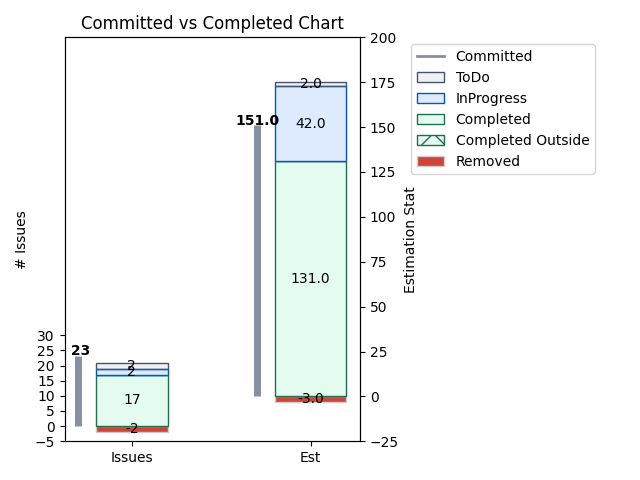
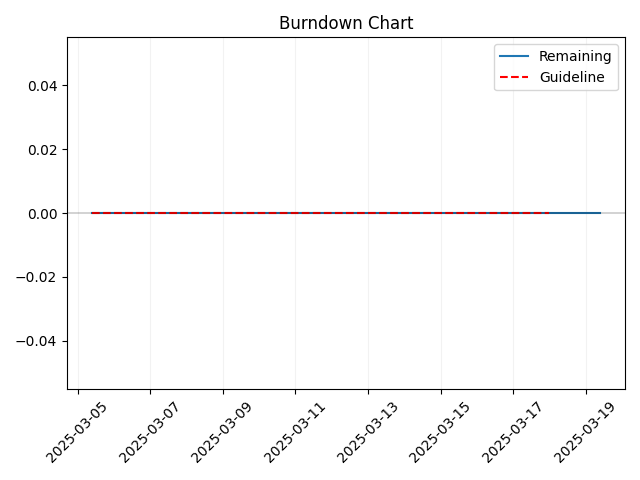

In [4]:

from IPython.display import clear_output, HTML, display
import os

debug_this_notebook = True
clear_output(wait=True) 

if debug_this_notebook == True:
	try:
		from google.colab import userdata
		os.getenv = userdata.get
	except:
		Warning("Not using google colab - defaulting to normal environment variables")
		pass        
	
	host = os.getenv("ATLASSIAN_HOST")
	username = os.getenv("ATLASSIAN_USERNAME")
	api_key = os.getenv("ATLASSIAN_APIKEY")
	zephyr_api = os.getenv("ZEPHYR_SCALE_APIKEY")

	if host[-1] != "/":
		host += "/"

	report = UltimateSprintReport(
		username=username, password=api_key, jira_url=host
	)
	
	boardId = 238
	sprintId = 961
	project = "FDSEWMSR"
	
	sprint_url = f"{host}jira/software/c/projects/{project}/boards/{boardId}/reports/sprint-retrospective?sprint={sprintId}"
	
	""" For testing purposes """ 
	"""
	report._set_sprint_details(sprint_url)
	report._load_sprint_report()
	report._load_status_categories()
	report._load_board_config()
	report._load_velocity_statistics()
	report._load_sprint_statistics()
	report._load_burndown() 
	display(HTML(report.show_burndown_table()))
	"""
	
	report.load_url(sprint_url)
	clear_output(wait=True) 
	if zephyr_api != None:
		report.load_sprint_zephyr_test_cast_statistics(zephyr_api)
	clear_output(wait=True) 
	display(HTML(report.show_report())) 
		
